# ML Models with Word2Vec

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, mean_squared_error, r2_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE 

In [3]:
df = pd.read_csv('My_Vader_Data.csv')

In [4]:
# Assuming df is your DataFrame
columns_to_drop = ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0']
df = df.drop(columns=columns_to_drop, axis=1)

In [5]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID,consumer_narrative,Sentiment_Score,Sentiment_Label,Anger_Level
0,06/28/21,Checking or savings account,Checking account,Managing an account,Problem accessing account,I had to report my card stolen and report frau...,NaN,"Populus Financial Group, Inc. (F/K/A Ace Cash ...",UT,84088,...,Consent provided,Web,07/22/21,Closed with explanation,Yes,4499000,report card stolen report fraudulent activity ...,-0.5267,Negative,Angry
1,06/28/21,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,Dear wise.com is a wire transfer company. \nI ...,NaN,TransferWise Ltd,NaN,XXXXX,...,Consent provided,Web,07/14/21,Closed with explanation,Yes,4499207,dear wisecom wire transfer company tryed send ...,0.8289,Positive,Not Angry
2,06/27/21,Mortgage,FHA mortgage,Applying for a mortgage or refinancing an exis...,NaN,"I was reluctant to think this, but it felt as ...",NaN,Synovus Bank,GA,30101,...,Consent provided,Web,06/27/21,Closed with explanation,Yes,4494886,wa reluctant think felt though discriminated t...,0.9505,Positive,Not Angry
3,07/01/21,Debt collection,Credit card debt,Written notification about debt,Didn't receive enough information to verify debt,I am not liable for this debt with XXXX and I ...,Company believes the complaint provided an opp...,"Mountain Run Solutions, LLC",OH,44112,...,Consent provided,Web,07/01/21,Closed with explanation,Yes,4507730,liable debt contract mountain run solution plu...,0.2960,Positive,Not Angry
4,02/13/21,"Payday loan, title loan, or personal loan",Payday loan,Can't contact lender or servicer,NaN,A form was faxed to a doctor office in the sam...,NaN,Four Directions Lending LLC,MI,48227,...,Consent provided,Web,03/03/21,Closed with explanation,Yes,4138020,form wa faxed doctor office building work stat...,-0.8456,Negative,Furious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230339,11/01/21,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,I recently check my credit report due to me ow...,NaN,PORTFOLIO RECOVERY ASSOCIATES INC,NJ,07110,...,Consent provided,Web,11/01/21,Closed with explanation,Yes,4864559,recently check credit report due owning busine...,-0.9965,Negative,Seething
230340,10/05/21,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,XX/XX/2021 RE : Foreclosure Sale TS No : XXXX ...,NaN,Quality Loan Service Corporation,CA,92026,...,Consent provided,Web,10/05/21,Closed with explanation,Yes,4782618,foreclosure sale quality loan service corporat...,0.9932,Positive,Not Angry
230341,08/06/21,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,NaN,This is an amendment to compliant XXXX-XXXX. I...,NaN,JPMORGAN CHASE & CO.,NC,28803,...,Consent provided,Web,08/06/21,Closed with explanation,Yes,4608059,amendment compliant amending complaint add ema...,-0.8273,Negative,Furious
230342,03/25/21,Mortgage,Conventional home mortgage,Closing on a mortgage,NaN,I've outlined my complaint to the bank below. ...,NaN,JPMORGAN CHASE & CO.,NY,11104,...,Consent provided,Web,03/25/21,Closed with explanation,Yes,4247481,ive outlined complaint bank despite flurry act...,0.9983,Positive,Not Angry


In [6]:
def preprocess_data(df, vector_size=100, window=5, min_count=1, test_size=0.2, validation_size=0.2, random_state=42):
    # Ensure 'consumer_narrative' column is of string type
    df['consumer_narrative'] = df['consumer_narrative'].astype(str)

    # Label encode the Anger_Level column in the dataset
    le = LabelEncoder()
    df['Anger_Level_encoded'] = le.fit_transform(df['Anger_Level'])

    # Split data into features and target
    X = df['consumer_narrative']
    y = df['Anger_Level_encoded']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Further split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state)

    # Tokenize sentences (assuming already tokenized)
    sentences_train = df.loc[X_train.index, 'consumer_narrative']
    sentences_val = df.loc[X_val.index, 'consumer_narrative']
    sentences_test = df.loc[X_test.index, 'consumer_narrative']

    # Train a Word2Vec model on the training data
    word2vec_model = Word2Vec(sentences_train, vector_size=vector_size, window=window, min_count=min_count, workers=4)

    # Function to get the Word2Vec embedding for a document
    def get_word2vec_embedding(tokens):
        embedding = np.mean([word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv], axis=0)
        if np.isnan(embedding).any():  # Handle cases where none of the words are in the Word2Vec model
            embedding = np.zeros(vector_size)
        return embedding

    # Get Word2Vec embeddings for training, validation, and testing data
    X_train_combined = np.array([get_word2vec_embedding(tokens) for tokens in sentences_train])
    X_val_combined = np.array([get_word2vec_embedding(tokens) for tokens in sentences_val])
    X_test_combined = np.array([get_word2vec_embedding(tokens) for tokens in sentences_test])

    return X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, word2vec_model, le

In [7]:
def train_and_evaluate_model(model, X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, le, random_state=42, patience=3):
    # Apply SMOTE to the training data
    smote = SMOTE(random_state=random_state)
    X_train_combined_res, y_train_res = smote.fit_resample(X_train_combined, y_train)

    # Define Stratified KFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # Cross-validation loop with early stopping (using custom implementation)
    best_score = 0
    patience_counter = 0

    start_training_time = time.time()  # Start timing the training process

    # Convert y_train to a NumPy array
    y_train_array = np.array(y_train_res)

    for train_index, val_index in skf.split(X_train_combined_res, y_train_array):
        X_train_fold, X_val_fold = X_train_combined_res[train_index], X_train_combined_res[val_index]
        y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)
        f1 = f1_score(y_val_fold, y_val_pred, average='weighted')

        if f1 > best_score:
            best_score = f1
            best_model = model
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

    end_training_time = time.time()  # End timing the training process
    training_time = end_training_time - start_training_time

    print("Best Cross-Validation F1-score:", best_score)

    # Train the model on the entire training data
    best_model.fit(X_train_combined_res, y_train_res)

    # Predict encoded anger levels for test data
    start_prediction_time = time.time()
    y_pred = best_model.predict(X_test_combined)
    end_prediction_time = time.time()
    prediction_time = end_prediction_time - start_prediction_time

    # Evaluation
    print("F1-score (weighted):", f1_score(y_test, y_pred, average='weighted'))
    print(classification_report(y_test, y_pred))

    # Confusion matrix with heatmap
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Anger Level (Encoded)')
    plt.ylabel('Actual Anger Level (Encoded)')
    plt.show()

    # ROC Curve and AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_combined)
    else:  # For models without predict_proba, use decision_function
        y_prob = model.decision_function(X_test_combined)
        y_prob = np.exp(y_prob) / np.sum(np.exp(y_prob), axis=1, keepdims=True)  # Softmax to convert to probabilities

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i, color in zip(range(len(le.classes_)), ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print training and prediction times
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Prediction Time: {prediction_time:.4f} seconds")

    # Compute and print MSE and R² score for training and validation sets
    y_train_pred = best_model.predict(X_train_combined_res)
    y_val_pred = best_model.predict(X_val_combined)

    train_mse = mean_squared_error(y_train_res, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train_res, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Validation MSE: {val_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

In [8]:
# Preprocess the data
X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, tfidf_vectorization_time, le = preprocess_data(df)

In [9]:
models = [
    LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    XGBClassifier(random_state=42, scale_pos_weight=1),
    LGBMClassifier(random_state=42, class_weight='balanced'),
    CatBoostClassifier(random_state=42, verbose=0)
]

Evaluating LogisticRegression
Best Cross-Validation F1-score: 0.3173435079970339
F1-score (weighted): 0.4352932781431685
              precision    recall  f1-score   support

           0       0.12      0.15      0.13      3779
           1       0.23      0.35      0.28      5440
           2       0.22      0.24      0.23      5380
           3       0.76      0.47      0.58     27579
           4       0.16      0.42      0.23      3891

    accuracy                           0.40     46069
   macro avg       0.30      0.33      0.29     46069
weighted avg       0.53      0.40      0.44     46069



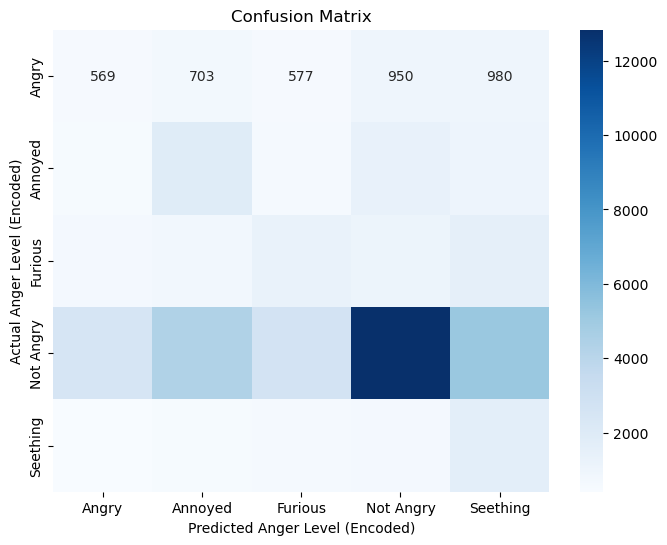

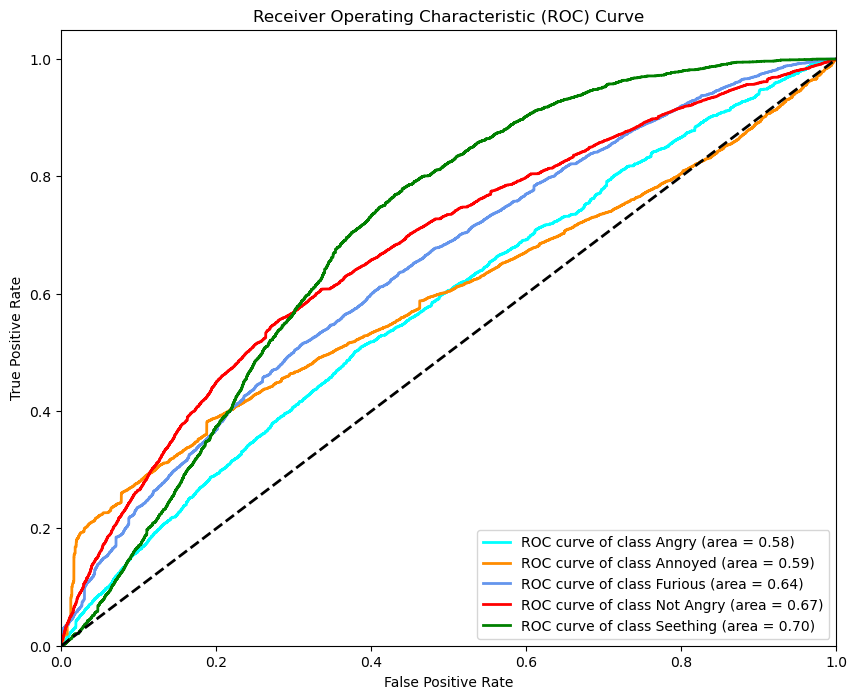

Training Time: 395.7153 seconds
Prediction Time: 0.0331 seconds
Validation MSE: 2.4934
Training R²: -0.7641
Validation R²: -1.2075


Evaluating RandomForestClassifier
Best Cross-Validation F1-score: 0.92934432638646
F1-score (weighted): 0.67554140758179
              precision    recall  f1-score   support

           0       0.44      0.36      0.40      3779
           1       0.72      0.48      0.58      5440
           2       0.52      0.43      0.47      5380
           3       0.77      0.84      0.80     27579
           4       0.43      0.52      0.47      3891

    accuracy                           0.68     46069
   macro avg       0.58      0.53      0.54     46069
weighted avg       0.68      0.68      0.68     46069



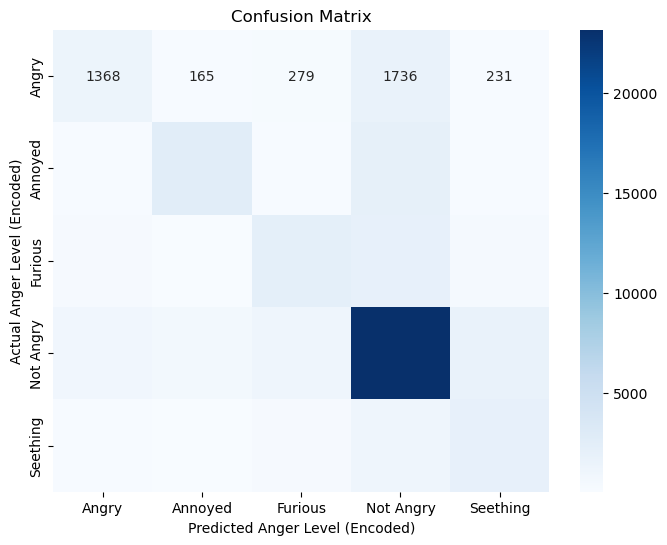

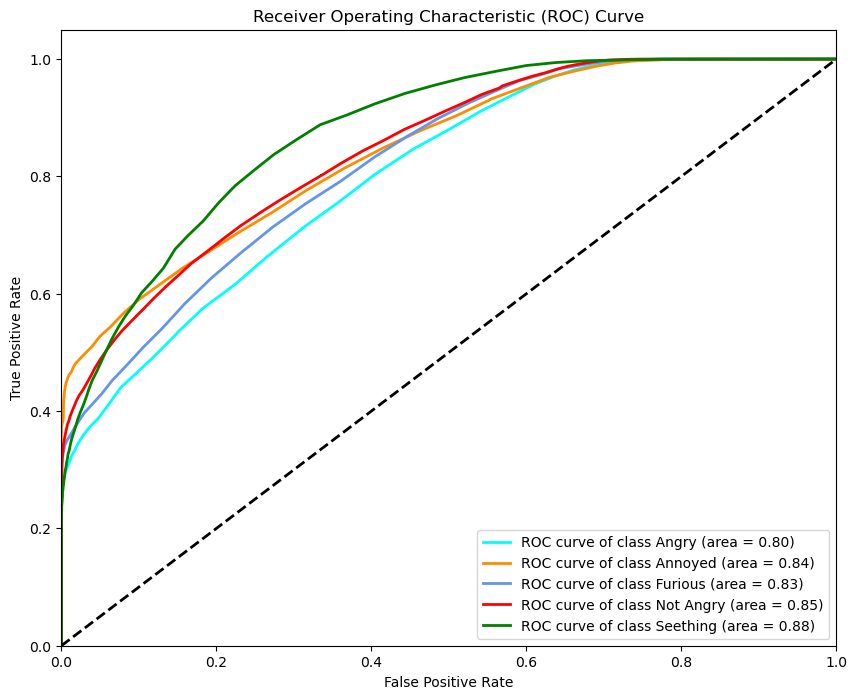

Training Time: 3636.9651 seconds
Prediction Time: 1.6582 seconds
Validation MSE: 1.2211
Training R²: 0.9986
Validation R²: -0.0811


Evaluating KNeighborsClassifier
Best Cross-Validation F1-score: 0.8570525337104107
F1-score (weighted): 0.5271004037255097
              precision    recall  f1-score   support

           0       0.24      0.47      0.32      3779
           1       0.40      0.57      0.47      5440
           2       0.33      0.51      0.40      5380
           3       0.89      0.47      0.61     27579
           4       0.28      0.58      0.38      3891

    accuracy                           0.49     46069
   macro avg       0.43      0.52      0.44     46069
weighted avg       0.66      0.49      0.53     46069



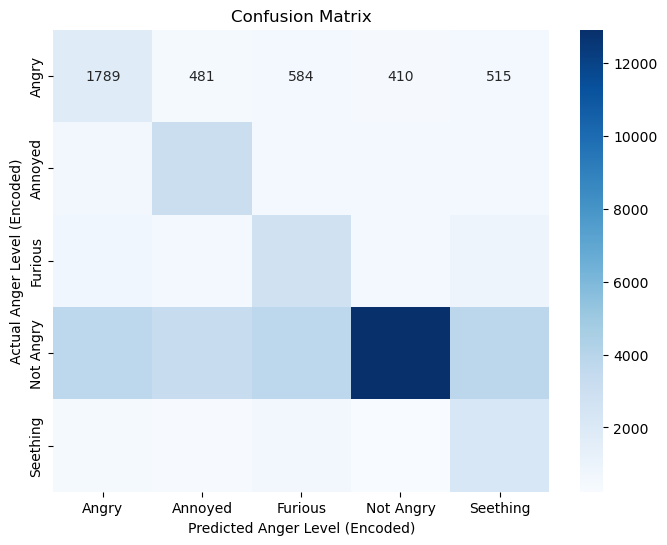

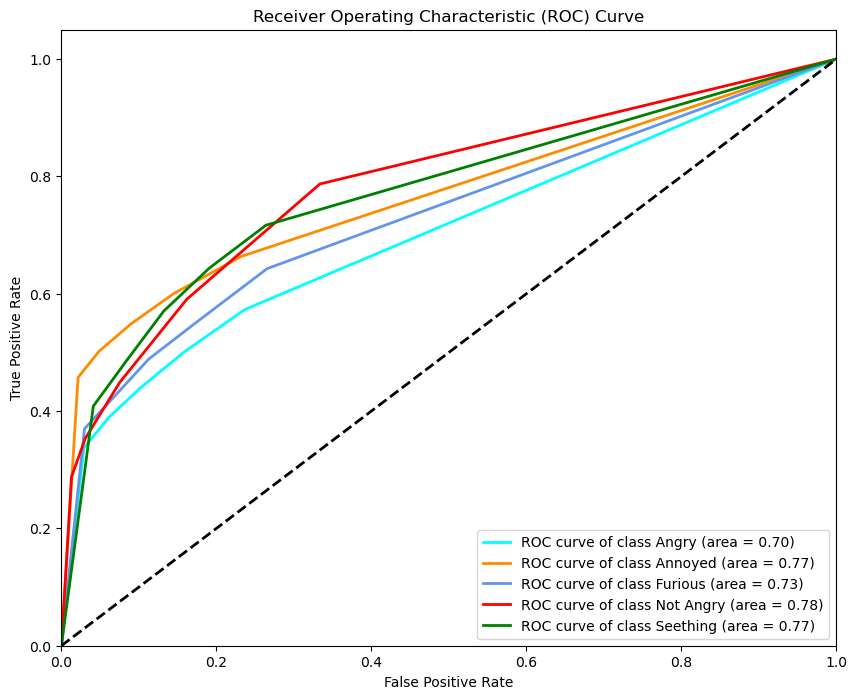

Training Time: 509.4580 seconds
Prediction Time: 84.3891 seconds
Validation MSE: 2.1064
Training R²: 0.8394
Validation R²: -0.8649


Evaluating DecisionTreeClassifier
Best Cross-Validation F1-score: 0.7349537627923898
F1-score (weighted): 0.5579754520907447
              precision    recall  f1-score   support

           0       0.24      0.39      0.30      3779
           1       0.39      0.53      0.45      5440
           2       0.34      0.44      0.38      5380
           3       0.80      0.59      0.68     27579
           4       0.30      0.42      0.35      3891

    accuracy                           0.53     46069
   macro avg       0.41      0.47      0.43     46069
weighted avg       0.61      0.53      0.56     46069



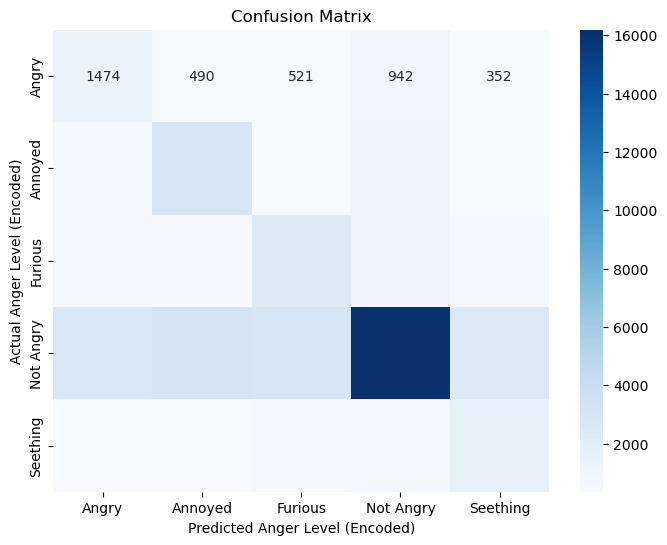

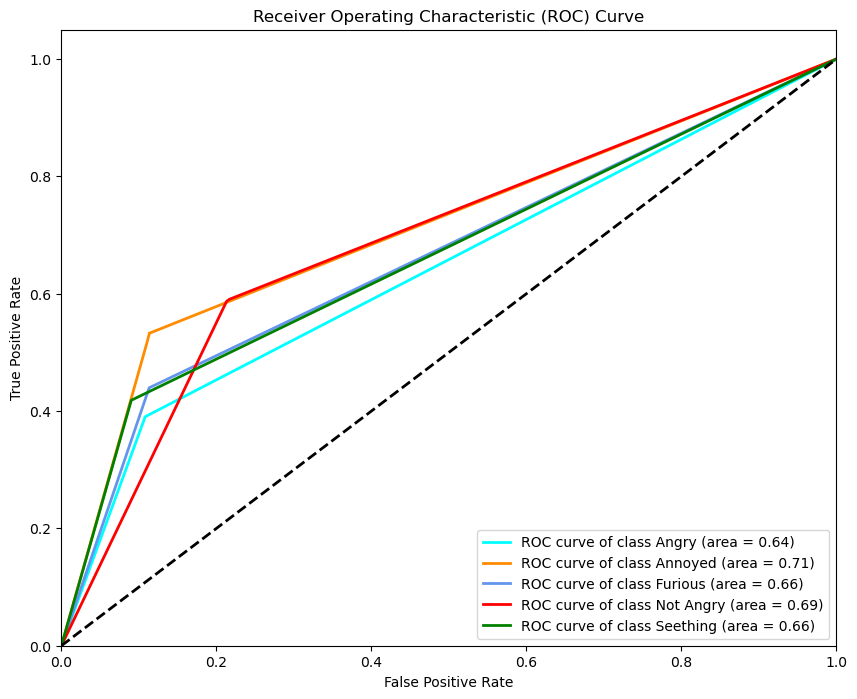

Training Time: 556.6354 seconds
Prediction Time: 0.0156 seconds
Validation MSE: 1.9465
Training R²: 0.9986
Validation R²: -0.7233


Evaluating XGBClassifier


C:\Users\pcudo\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:53:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pcudo\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pcudo\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:55:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pcudo\anaconda3\Lib\site-packages\xgb

Best Cross-Validation F1-score: 0.6258845222388295


C:\Users\pcudo\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:58:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


F1-score (weighted): 0.5735220137489665
              precision    recall  f1-score   support

           0       0.24      0.40      0.30      3779
           1       0.48      0.46      0.47      5440
           2       0.38      0.39      0.39      5380
           3       0.82      0.60      0.69     27579
           4       0.28      0.61      0.38      3891

    accuracy                           0.55     46069
   macro avg       0.44      0.49      0.45     46069
weighted avg       0.63      0.55      0.57     46069



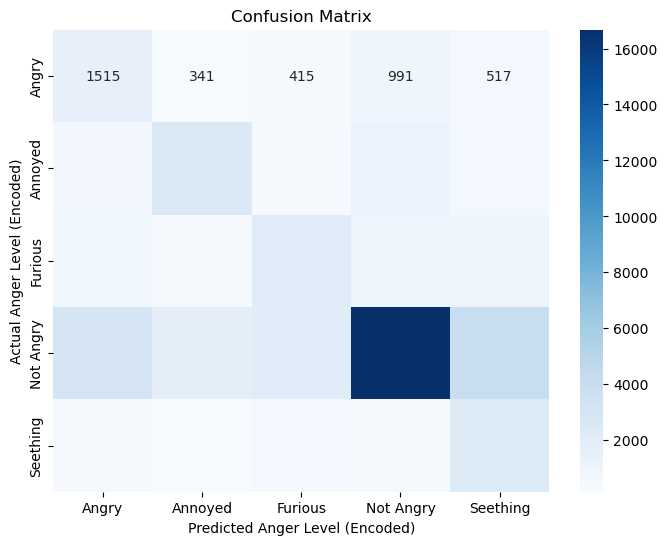

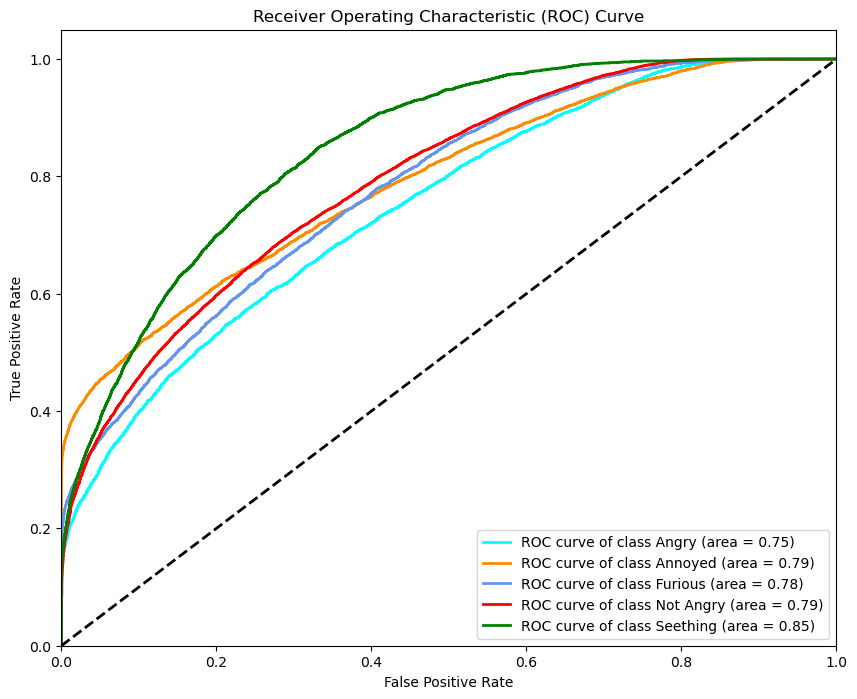

Training Time: 273.1840 seconds
Prediction Time: 0.1923 seconds
Validation MSE: 1.9537
Training R²: 0.0959
Validation R²: -0.7296


Evaluating LGBMClassifier
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 353124, number of used features: 100
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 353124, number of used fe

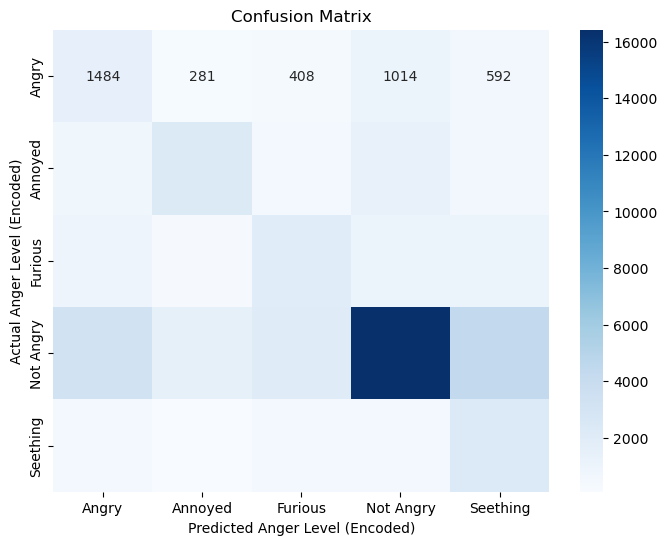

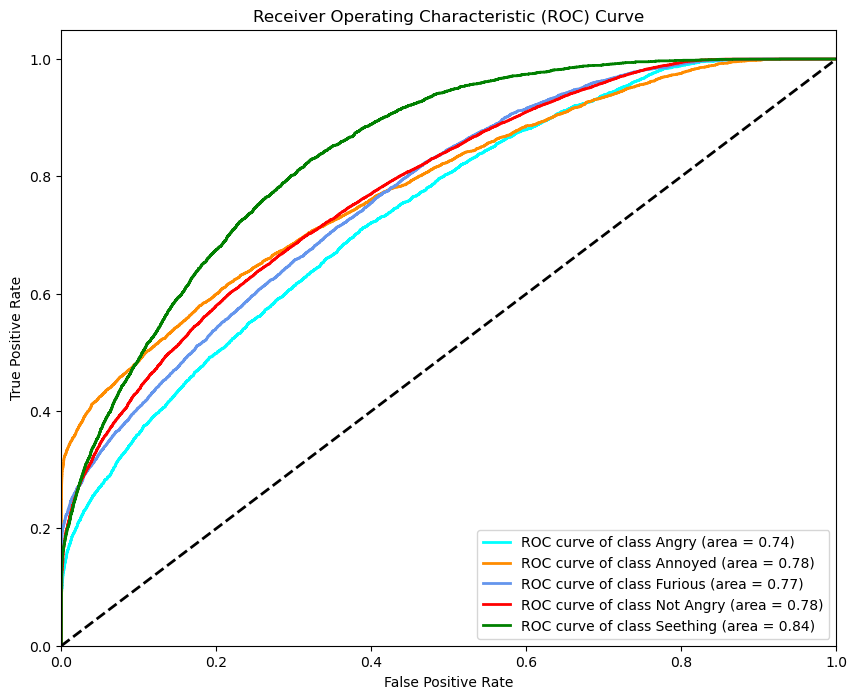

Training Time: 161.0479 seconds
Prediction Time: 1.3531 seconds
Validation MSE: 2.0160
Training R²: -0.1823
Validation R²: -0.7848


Evaluating CatBoostClassifier
Best Cross-Validation F1-score: 0.6275156195526989
F1-score (weighted): 0.5712702076651901
              precision    recall  f1-score   support

           0       0.23      0.40      0.29      3779
           1       0.47      0.45      0.46      5440
           2       0.37      0.39      0.38      5380
           3       0.81      0.61      0.69     27579
           4       0.29      0.58      0.38      3891

    accuracy                           0.55     46069
   macro avg       0.43      0.49      0.44     46069
weighted avg       0.63      0.55      0.57     46069



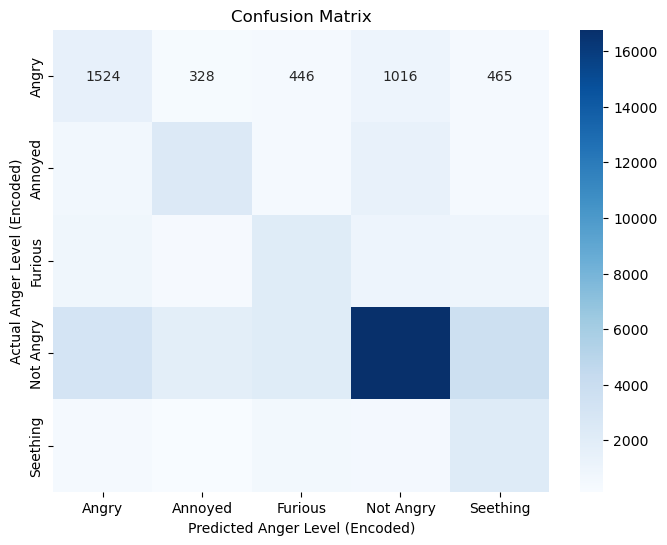

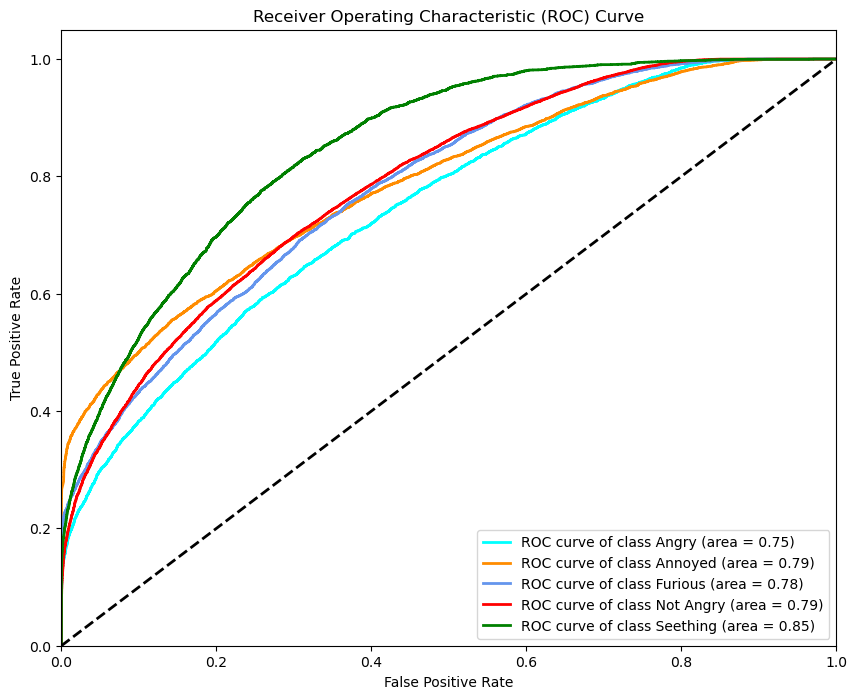

Training Time: 2322.6944 seconds
Prediction Time: 0.2630 seconds
Validation MSE: 1.9436
Training R²: 0.1035
Validation R²: -0.7207




In [10]:
for model in models:
    print(f"Evaluating {model.__class__.__name__}")
    train_and_evaluate_model(model, X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, le)
    print("\n" + "="*80 + "\n")

# Deep Learning Models (CNN, LSTM, GRU)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, GRU
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import  KFold
from keras.layers import Input
from keras.callbacks import EarlyStopping

In [12]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(input_shape, num_classes):
    model = Sequential()
    model.add(GRU(128, input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, le, random_state=42, patience=3):
    # Apply SMOTE to the training data
    smote = SMOTE(random_state=random_state)
    X_train_combined_res, y_train_res = smote.fit_resample(X_train_combined, y_train)

    # Convert labels to categorical
    y_train_res_cat = to_categorical(y_train_res)
    y_val_cat = to_categorical(y_val)
    y_test_cat = to_categorical(y_test)

    # Reshape data for CNN/LSTM/GRU input
    X_train_combined_res = X_train_combined_res.reshape(X_train_combined_res.shape[0], X_train_combined_res.shape[1], 1)
    X_val_combined = X_val_combined.reshape(X_val_combined.shape[0], X_val_combined.shape[1], 1)
    X_test_combined = X_test_combined.reshape(X_test_combined.shape[0], X_test_combined.shape[1], 1)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    start_training_time = time.time()
    history = model.fit(X_train_combined_res, y_train_res_cat, validation_data=(X_val_combined, y_val_cat), epochs=100, batch_size=32, callbacks=[early_stopping])
    end_training_time = time.time()
    training_time = end_training_time - start_training_time

    start_prediction_time = time.time()
    y_pred_prob = model.predict(X_test_combined)
    y_pred = np.argmax(y_pred_prob, axis=1)
    end_prediction_time = time.time()
    prediction_time = end_prediction_time - start_prediction_time

    # Evaluation
    print("F1-score (weighted):", f1_score(y_test, y_pred, average='weighted'))
    print(classification_report(y_test, y_pred))

    # Confusion matrix with heatmap
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Anger Level (Encoded)')
    plt.ylabel('Actual Anger Level (Encoded)')
    plt.show()

    # ROC Curve and AUC
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i, color in zip(range(len(le.classes_)), ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print training and prediction times
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Prediction Time: {prediction_time:.4f} seconds")

    # Compute and print MSE and R² score for training and validation sets
    y_train_pred_prob = model.predict(X_train_combined_res)
    y_val_pred_prob = model.predict(X_val_combined)
    y_train_pred = np.argmax(y_train_pred_prob, axis=1)
    y_val_pred = np.argmax(y_val_pred_prob, axis=1)

    train_mse = mean_squared_error(y_train_res, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train_res, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Validation MSE: {val_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

C:\Users\pcudo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
C:\Users\pcudo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Evaluating CNN model
Epoch 1/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 124s 9ms/step - accuracy: 0.3647 - loss: 1.4428 - val_accuracy: 0.4886 - val_loss: 1.2957
Epoch 2/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 118s 9ms/step - accuracy: 0.4390 - loss: 1.3131 - val_accuracy: 0.4489 - val_loss: 1.3313
Epoch 3/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 118s 9ms/step - accuracy: 0.4608 - loss: 1.2711 - val_accuracy: 0.4539 - val_loss: 1.3211
Epoch 4/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 115s 8ms/step - accuracy: 0.4739 - loss: 1.2446 - val_accuracy: 0.4550 - val_loss: 1.3221
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
F1-score (weighted): 0.5168685600051234
              precision    recall  f1-score   support

           0       0.18      0.23      0.20      3779
           1       0.46      0.33      0.38      5440
           2       0.27      0.29      0.28      5380
           3       0.77      0.58      0.66     27579
           4       0.22      0.63      0.33      3891

    accuracy                  

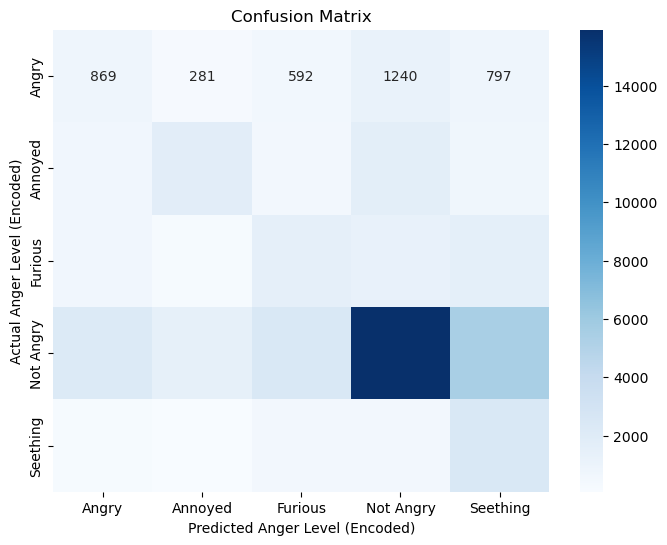

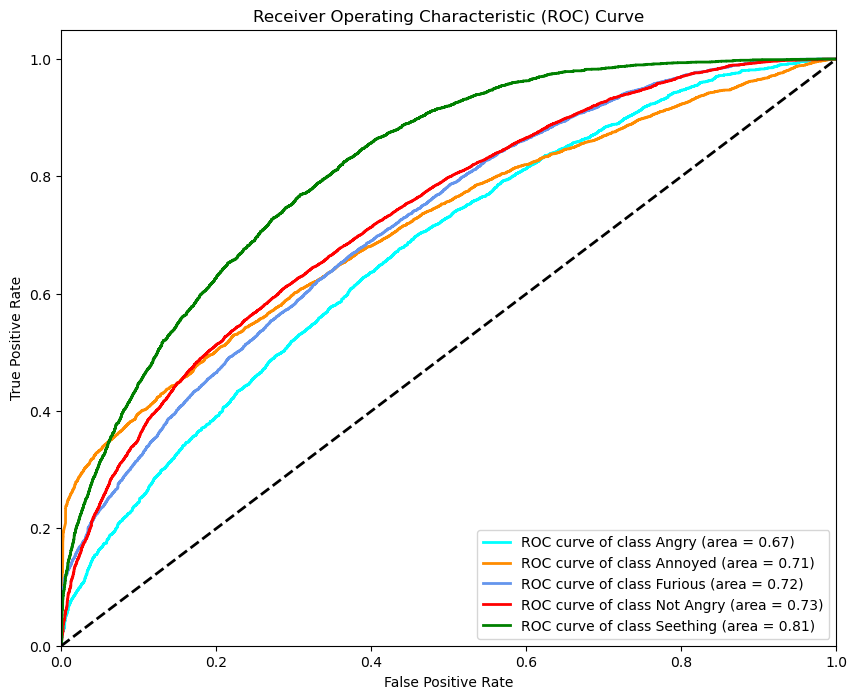

Training Time: 475.1613 seconds
Prediction Time: 4.8497 seconds
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Validation MSE: 1.9874
Training R²: -0.5400
Validation R²: -0.7595


Evaluating LSTM model
Epoch 1/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 1002s 72ms/step - accuracy: 0.2419 - loss: 1.5870 - val_accuracy: 0.2571 - val_loss: 1.5803
Epoch 2/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 977s 71ms/step - accuracy: 0.3442 - loss: 1.4688 - val_accuracy: 0.3961 - val_loss: 1.4299
Epoch 3/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 985s 71ms/step - accuracy: 0.3994 - loss: 1.3887 - val_accuracy: 0.4457 - val_loss: 1.3538
Epoch 4/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 984s 71ms/step - accuracy: 0.4259 - loss: 1.3391 - val_accuracy: 0.4527 - val_loss: 1.3339
Epoch 5/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 1049s 76ms/step - accuracy: 0.4452 - loss: 1.3014 - val_accuracy: 0.4319 - val_loss: 1.3452
Epoch 6/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 1129s 82ms/step - accuracy: 0

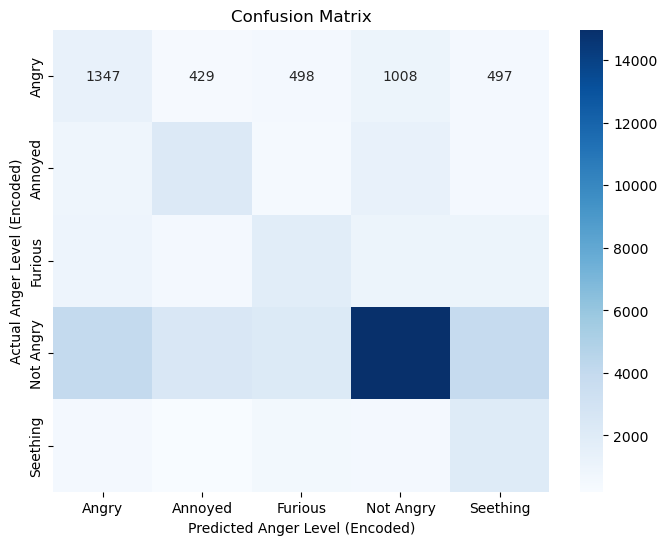

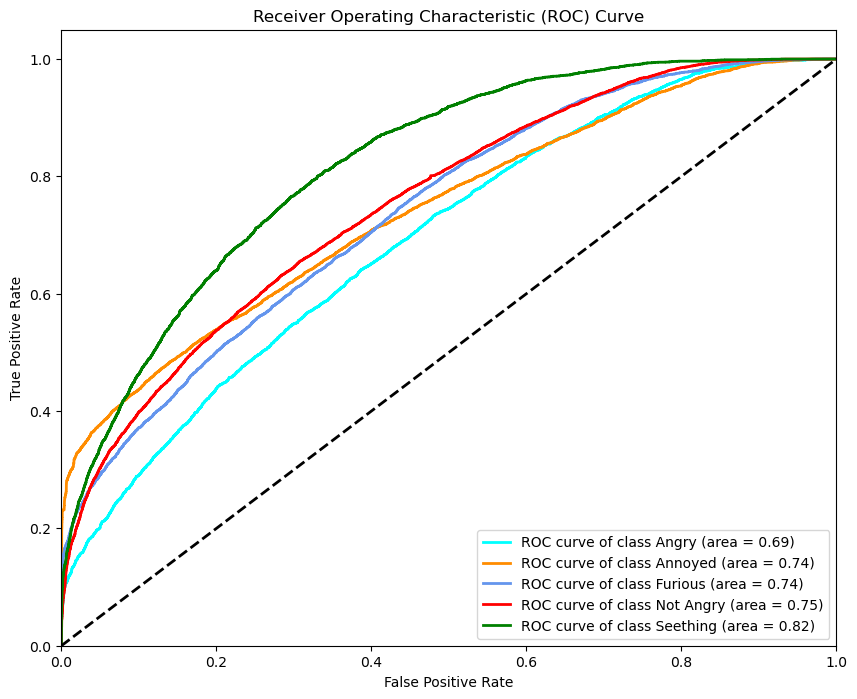

Training Time: 12035.9581 seconds
Prediction Time: 75.6987 seconds
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 695s 50ms/step
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 63s 55ms/step
Validation MSE: 2.2656
Training R²: -0.3415
Validation R²: -1.0058


Evaluating GRU model
Epoch 1/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 1309s 95ms/step - accuracy: 0.2235 - loss: 1.6064 - val_accuracy: 0.1212 - val_loss: 1.6055
Epoch 2/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 1299s 94ms/step - accuracy: 0.2430 - loss: 1.5893 - val_accuracy: 0.1059 - val_loss: 1.6169
Epoch 3/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 1319s 96ms/step - accuracy: 0.2385 - loss: 1.5914 - val_accuracy: 0.1731 - val_loss: 1.5812
Epoch 4/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 1310s 95ms/step - accuracy: 0.2653 - loss: 1.5730 - val_accuracy: 0.1597 - val_loss: 1.6076
Epoch 5/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 1352s 98ms/step - accuracy: 0.2936 - loss: 1.5467 - val_accuracy: 0.2238 - val_loss: 1.6278
Epoch 6/100
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 1339s 97ms/step - ac

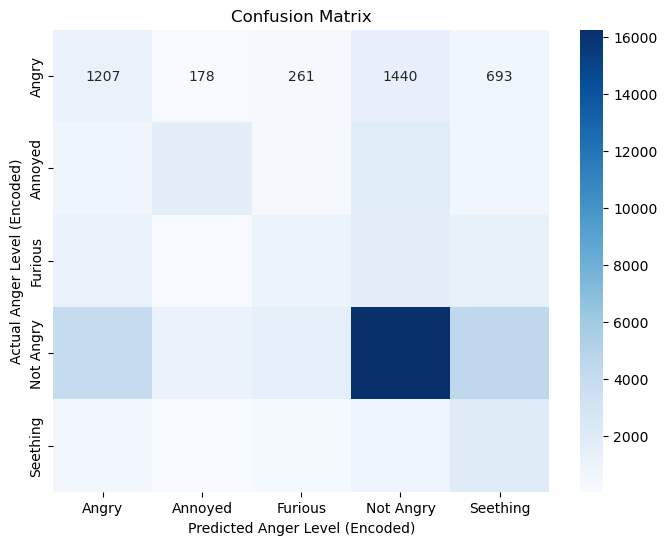

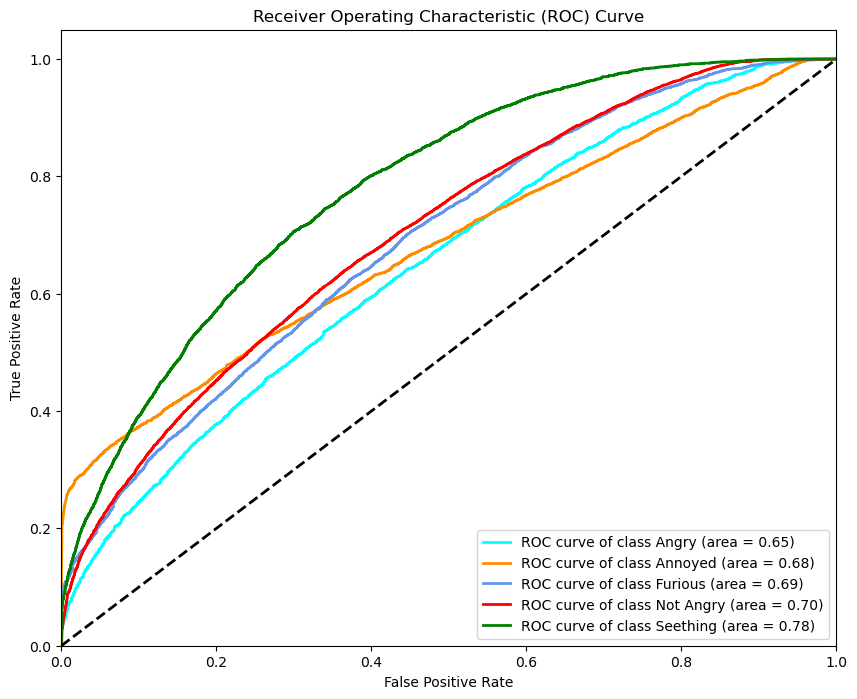

Training Time: 28018.9619 seconds
Prediction Time: 60.5523 seconds
13794/13794 ━━━━━━━━━━━━━━━━━━━━ 557s 40ms/step
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step
Validation MSE: 2.4301
Training R²: -0.5933
Validation R²: -1.1514




In [13]:
# Define models
input_shape = (X_train_combined.shape[1], 1)
num_classes = len(np.unique(y_train))
cnn_model = build_cnn_model(input_shape, num_classes)
lstm_model = build_lstm_model(input_shape, num_classes)
gru_model = build_gru_model(input_shape, num_classes)

# Train and evaluate each model
models = [cnn_model, lstm_model, gru_model]
model_names = ["CNN", "LSTM", "GRU"]

for model, name in zip(models, model_names):
    print(f"Evaluating {name} model")
    train_and_evaluate_model(model, X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test, le)
    print("\n" + "="*80 + "\n")